In [2]:
%matplotlib inline

# IP Map (or, who the hell keeps knocking?)

I keep getting a shitload of attempted logins to my home machine, which has a public-facing SSH socket on the default port. However, I'm curious where these are all coming from. A cursory check of a few of the IPs seem to point mostly to Russia and China.

The goal of this notebook is to generate a heatmap overlaid on a map of the world of where these attempted logins are coming from.

## Read in `auth.log`

In [1]:
logfile = "/var/log/auth.log.1"

infile = open(logfile, 'r')
text = infile.readlines()

## Parse out lines corresponding to failed SSH logins

In [2]:
# filtered_text = list(filter(lambda x: "Failed" in x and not "repeated" in x, text))
filtered_text = list(filter(lambda x: "[preauth]" in x, text))

## Get IPs from parsed lines

In [3]:
import re

ips = [x[0] for x in map(lambda x: re.findall( r'[0-9]+(?:\.[0-9]+){3}', x), filtered_text) if not x == []]

## Select out only unique entries

In [4]:
old = len(ips)
ips = set(ips)
new = len(ips)

print("Cut %d IPs down to %d unique IPs." % (old, new))

Cut 0 IPs down to 0 unique IPs.


## Set up geolocation database

In [5]:
import geoip2.database
reader = geoip2.database.Reader('GeoLite2-City_20170704/GeoLite2-City.mmdb')

## Generate list of (lat, lon, accuracy radius) for each IP

In [6]:
cities = []
failed = 0
for ip in ips:
    try:
        response = reader.city(ip)
        cities.append(response)
    except:
        failed += 1
print("%d lookups failed" % failed)
countries = [city.country.name for city in cities]
locs = [[city.location.latitude, city.location.longitude, city.location.accuracy_radius] for city in cities]

0 lookups failed


In [7]:
locs[0]

IndexError: list index out of range

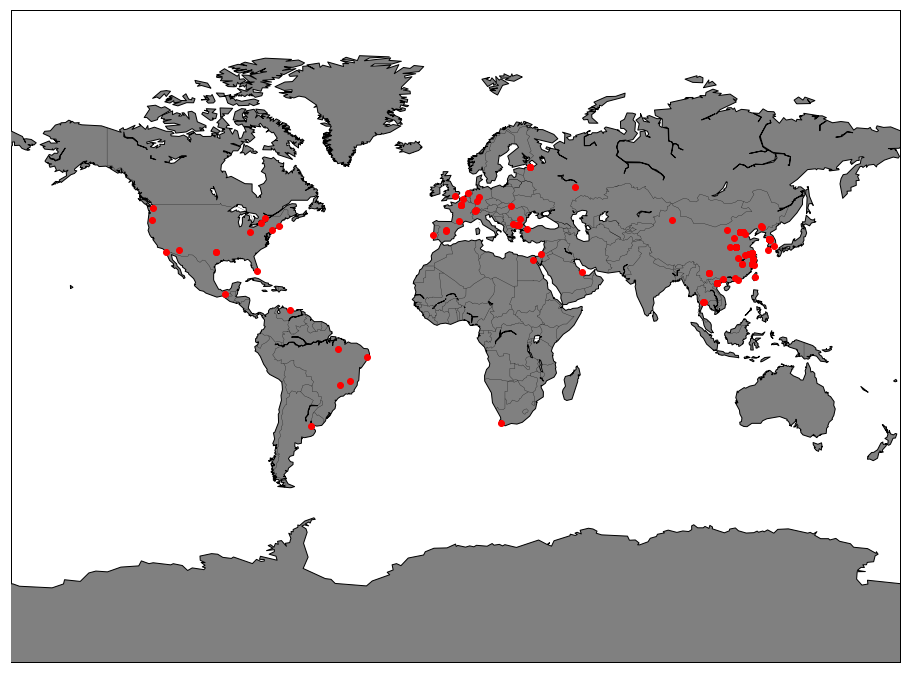

In [30]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 12)

map = Basemap(projection='mill',lon_0=0)
map.drawcoastlines()

map.drawmapboundary(fill_color='white', zorder=0)
map.drawcountries(linewidth=0.25)
map.fillcontinents(color='grey',lake_color='white', zorder=1);

for loc in locs[0:-1]:
    x, y = map(loc[1],loc[0])
    map.plot(x, y, marker='o', color='red', linestyle='None', zorder=2)